# Библиотеки и функции

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import savgol_filter
try:
    from xgboost import XGBClassifier
except ModuleNotFoundError:
    !pip install xgboost
    from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
try:
    from peakutils import baseline
except ModuleNotFoundError:
    !pip install peakutils
    from peakutils import baseline
try:
    import shap
except ModuleNotFoundError:
    !pip install shap
    import shap

In [6]:
# размер графиков
plt.rcParams["figure.figsize"] = (10.8, 4.8)
font = {'family': 'Times New Roman',
        'size': 12}
matplotlib.rc('font', **font)

# загрузка данных из директории в один DataFrame
def load_df(files: list[str],
            path_to_folder: str = 'data',
            ) -> pd.DataFrame:

    df = pd.DataFrame()
    for file in files:
        file_path = os.path.join(path_to_folder, file)
        sub_df = pd.read_csv(file_path, delimiter='\t', header=None, skiprows=1)
        sub_df.columns = ['X', 'Y', 'Wave', 'Intensity']
        sub_df = sub_df.pivot_table(
            index=['X', 'Y'], columns='Wave', values='Intensity', aggfunc='first').reset_index()
        sub_df.columns.name = None
        sub_df['Label'] = file.split('_')[1]
        if not df.empty:
            sub_df.columns = df.columns
        df = pd.concat([df, sub_df], ignore_index=True)

    return df

# однотипная отрисовка большого числа графиков
def draw(y_matrix_list: list[np.ndarray] | np.ndarray, 
         x_row_list: list[np.ndarray] | np.ndarray, 
         n_subplots: int = 1, 
         titles: list[str] | str = 'Спектры', 
         y_label: str = 'Интенсивность, отн. ед.',
         x_label: str = 'Рамановский сдвиг, см⁻¹',
         save_name: str | None = None
         ) -> None:
    
    for i in range(n_subplots):
        if type(y_matrix_list) == list:
            y_matrix = y_matrix_list[i]
        else:
            y_matrix = y_matrix_list
        if type(x_row_list) == list:
            x_row = x_row_list[i]
        else:
            x_row = x_row_list
        if type(titles) == list:
            title = titles[i]
        else:
            title = titles
        plt.subplot(1, n_subplots, i+1)
        for y_row in y_matrix:
            plt.plot(x_row, y_row)
        plt.title(title)
        plt.ylabel(y_label)
        plt.xlabel(x_label)

    if save_name is not None:
        plt.savefig(save_name, dpi=600)
    plt.show()

# Предобработка

In [3]:
files = os.listdir('data')
df = load_df(files)

# фичи - нормализованные значения интенсивности для каждой длины волны
X = np.array(df.iloc[:, 2:-1], dtype='float')
# таргеты - ответы control, endo и exo, закодированные one-hot'ом
Y = np.array(pd.get_dummies(df['Label']), dtype='int')
wavelengths = np.round(np.array(df.columns[2:-1], dtype='float'), 2)

scaler = StandardScaler()
X = scaler.fit_transform(X.T).T
#for i in range(X.shape[0]):
#    X[i, :] -= np.mean(X[i, :])
#X /= np.std(X)

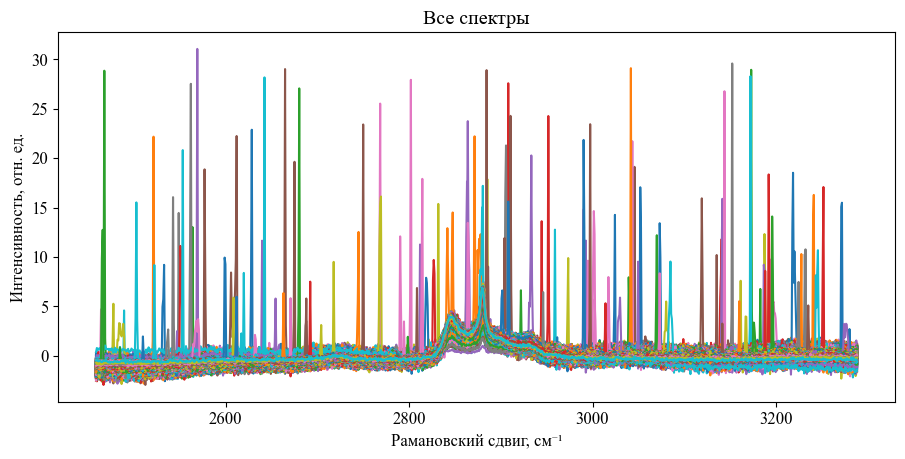

In [7]:
draw(X, wavelengths, titles='Все спектры', save_name='images/all_spectra')

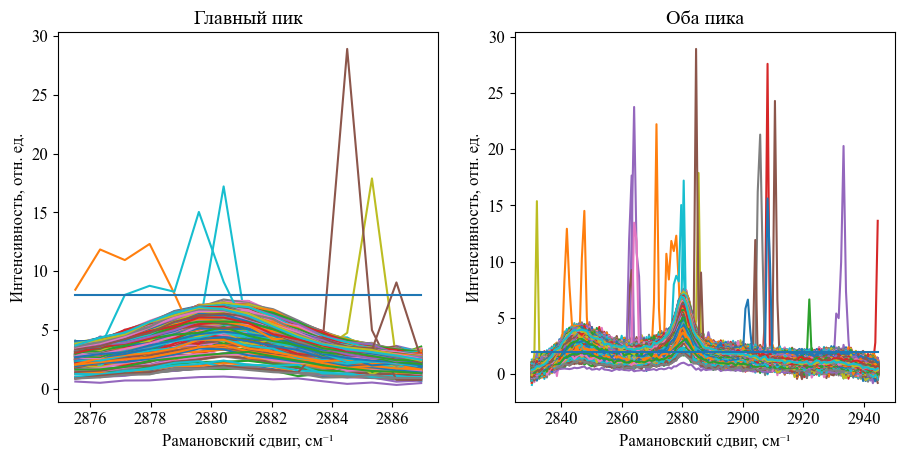

In [8]:
# Эмпирически подобранные максимальное значение для пика и координаты "окна", в котором нормальный пик расположен
topvalue = 8
#topvalue = 23
peak_start = 485
peak_end = 500
topline = np.ones(15) * topvalue

# И еще один эмпирический максимум - теперь вне пика. Предыдущие условия не покрывают все выбросы
middletopvalue = 2
widepeak_start = 430
widepeak_end = 571
middletopline = np.ones(widepeak_end - widepeak_start) * middletopvalue

draw(
    [np.vstack((X[:, peak_start:peak_end], topline)),
     np.vstack((X[:, widepeak_start:widepeak_end], middletopline))],
    [wavelengths[peak_start:peak_end],
     wavelengths[widepeak_start:widepeak_end]],
     n_subplots=2,
     titles=['Главный пик', 'Оба пика']
)

Удалено выбросов:   129
Измерений осталось: 9321
Потери:             1.37%


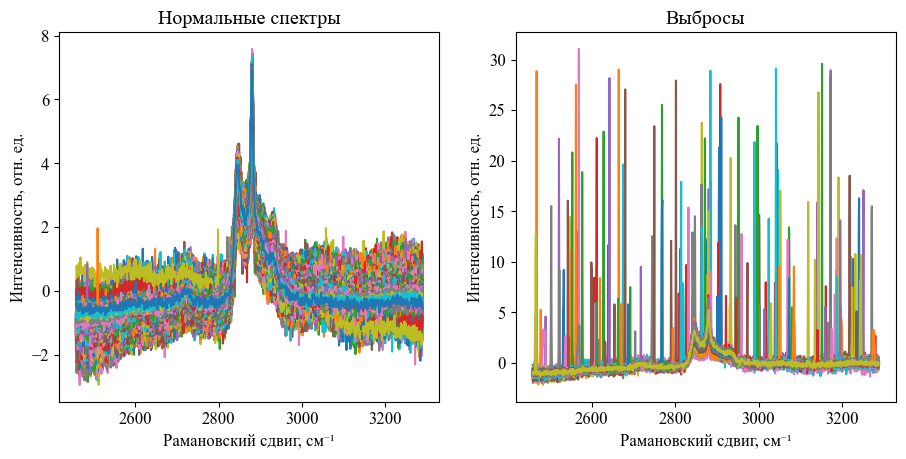

In [9]:
max_values = np.max(X, axis=1)
max_indices = np.argmax(X, axis=1)
max_values_off_peak = np.max(np.concatenate((X[:, :widepeak_start], X[:, widepeak_end:]), axis=1), axis=1)

# bool-маска для выбросов, учитывающая все условия
outlier_detector = (
    max_values > topvalue) | (
    max_indices < peak_start) | (
    max_indices > peak_end) | (
    max_values_off_peak > middletopvalue)

X_normal = X[~outlier_detector, :]
X_outlier = X[outlier_detector, :]

Y_normal = Y[~outlier_detector, :]
Y_outlier = Y[outlier_detector, :]

print('Удалено выбросов:  ', X_outlier.shape[0])
print('Измерений осталось:', X_normal.shape[0])
print('Потери:            ', str(np.round(100 * X_outlier.shape[0] / X.shape[0], 2)) + '%')

draw([X_normal, X_outlier], wavelengths, n_subplots=2, 
     titles=['Нормальные спектры', 'Выбросы'], save_name='images/outliers_separated.png')

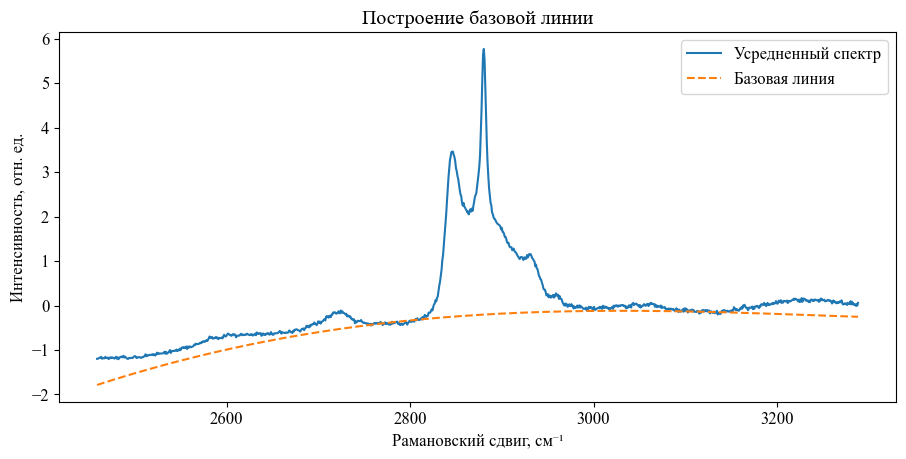

In [10]:
avg = np.mean(X_normal, axis=0)
bl = baseline(avg, deg=None)

plt.plot(wavelengths, avg, label='Усредненный спектр')
plt.plot(wavelengths, bl, label='Базовая линия', linestyle='--')
plt.xlabel('Рамановский сдвиг, см⁻¹')
plt.ylabel('Интенсивность, отн. ед.')
plt.title('Построение базовой линии')
plt.legend()
plt.savefig('images/baseline_correction.png', dpi=600)
plt.show()

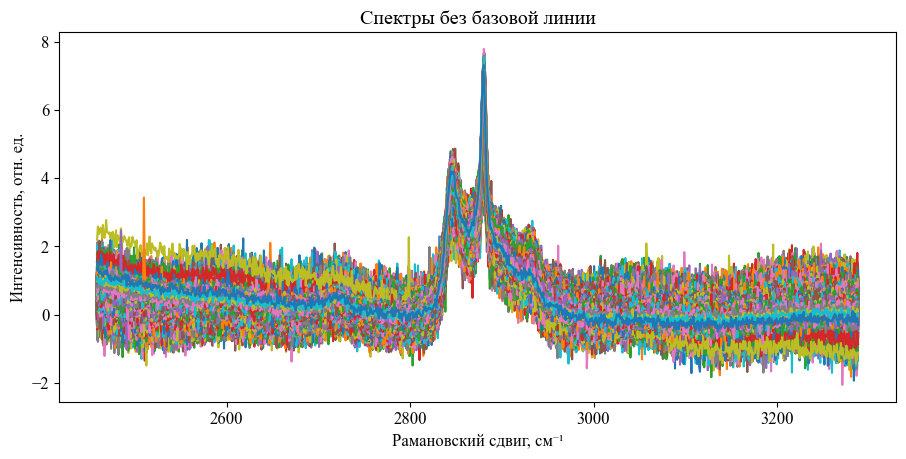

In [11]:
X_clear = X_normal - bl

draw(X_clear, wavelengths, titles='Спектры без базовой линии',
     save_name='images/baseline_subtracted.png')

# Обработка

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_clear, Y_normal, test_size=0.25, random_state=0)
# labels - это перекодированные из one-hot в простые числовые индексы (0, 1, 2) те же ответы
Y_train_labels = np.argmax(Y_train, axis=1)
Y_test_labels = np.argmax(Y_test, axis=1)

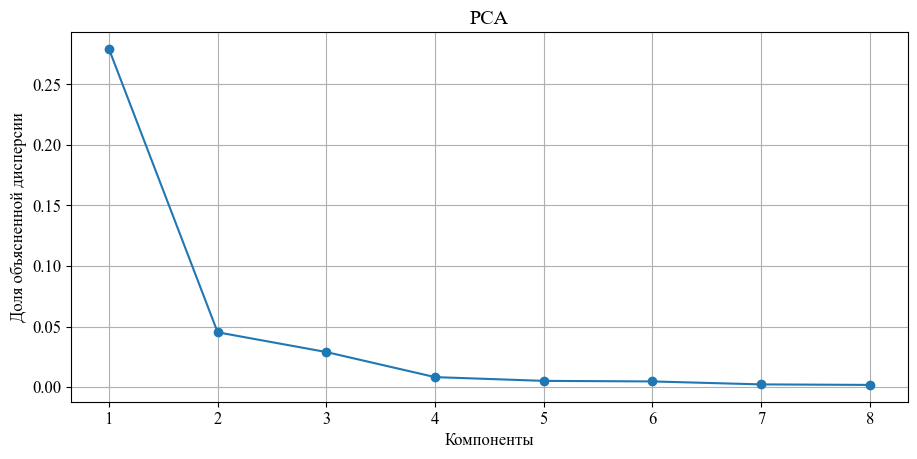

In [13]:
pca = PCA(n_components=8)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

ev = pca.explained_variance_ratio_

plt.plot(np.arange(1, len(ev) + 1), ev, marker='o')
plt.ylabel('Доля объясненной дисперсии')
plt.xlabel('Компоненты')
plt.title('PCA')
plt.grid(True)
plt.show()

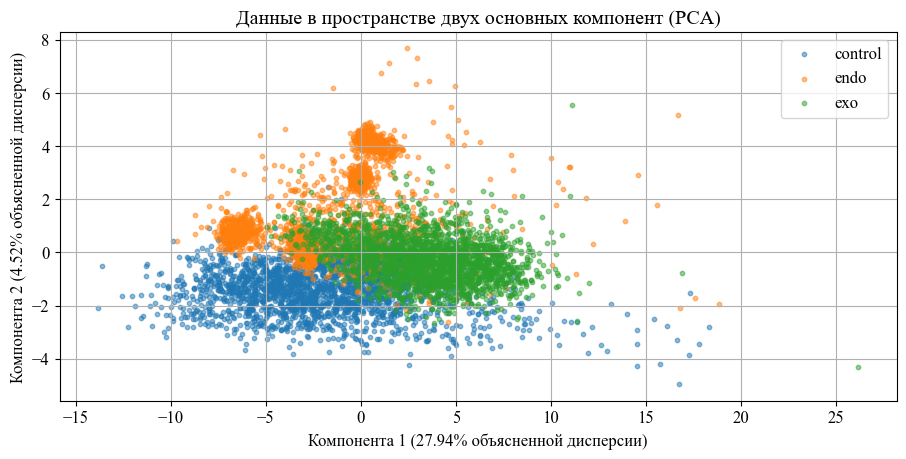

In [14]:
plt.scatter(X_train_pca[:, 0][Y_train_labels == 0],
            X_train_pca[:, 1][Y_train_labels == 0], alpha=0.5, s=10, label='control')
plt.scatter(X_train_pca[:, 0][Y_train_labels == 1],
            X_train_pca[:, 1][Y_train_labels == 1], alpha=0.5, s=10, label='endo')
plt.scatter(X_train_pca[:, 0][Y_train_labels == 2],
            X_train_pca[:, 1][Y_train_labels == 2], alpha=0.5, s=10, label='exo')
plt.xlabel('Компонента 1 ({:.2f}% объясненной дисперсии)'.format(
    ev[0]*100))
plt.ylabel('Компонента 2 ({:.2f}% объясненной дисперсии)'.format(
    ev[1]*100))
plt.title('Данные в пространстве двух основных компонент (PCA)')
plt.grid(True)
plt.legend()
plt.savefig('images/data_in_pca_space.png', dpi=600)
plt.show()

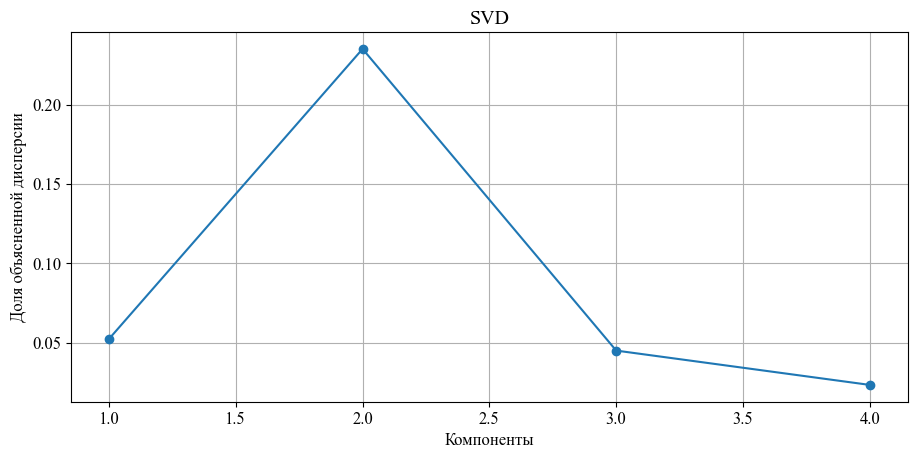

In [20]:
svd = TruncatedSVD(n_components=4)

X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

ev = svd.explained_variance_ratio_

plt.plot(np.arange(1, len(ev) + 1), ev, marker='o')
plt.ylabel('Доля объясненной дисперсии')
plt.xlabel('Компоненты')
plt.title('SVD')
plt.grid(True)
plt.show()

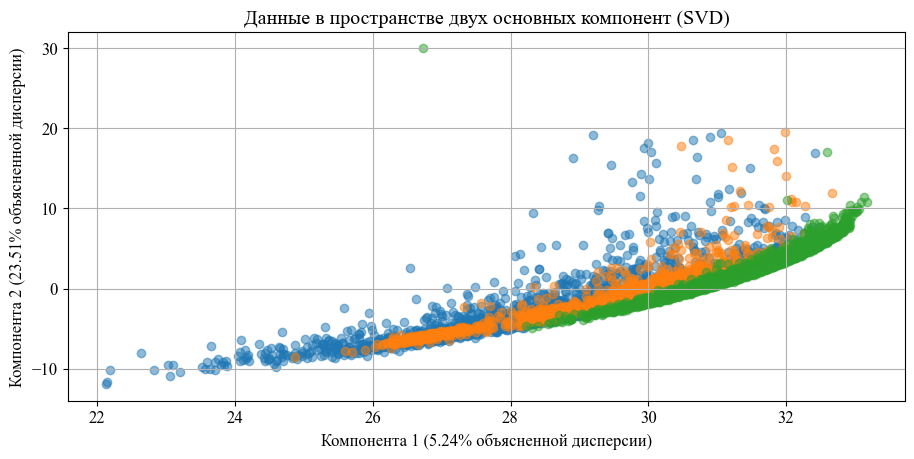

In [21]:
plt.scatter(X_train_svd[:, 0][Y_train_labels == 0],
            X_train_svd[:, 1][Y_train_labels == 0], alpha=0.5)
plt.scatter(X_train_svd[:, 0][Y_train_labels == 1],
            X_train_svd[:, 1][Y_train_labels == 1], alpha=0.5)
plt.scatter(X_train_svd[:, 0][Y_train_labels == 2],
            X_train_svd[:, 1][Y_train_labels == 2], alpha=0.5)
plt.xlabel('Компонента 1 ({:.2f}% объясненной дисперсии)'.format(
    ev[0]*100))
plt.ylabel('Компонента 2 ({:.2f}% объясненной дисперсии)'.format(
    ev[1]*100))
plt.title('Данные в пространстве двух основных компонент (SVD)')
plt.grid(True)
plt.show()

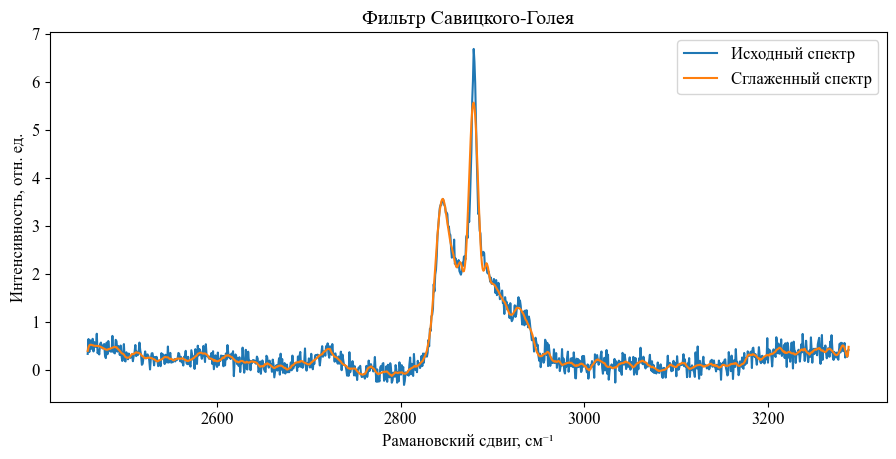

In [15]:
window_size = 50
polyorder = 8

X_train_savgol = savgol_filter(X_train, window_size, polyorder)
X_test_savgol = savgol_filter(X_test, window_size, polyorder)

plt.plot(wavelengths, X_train[1, :], label='Исходный спектр')
plt.plot(wavelengths, X_train_savgol[1, :], label='Сглаженный спектр')
plt.xlabel('Рамановский сдвиг, см⁻¹')
plt.ylabel('Интенсивность, отн. ед.')
plt.title('Фильтр Савицкого-Голея')
plt.legend()
plt.savefig('images/savgol_filter.png', dpi=600)
plt.show()

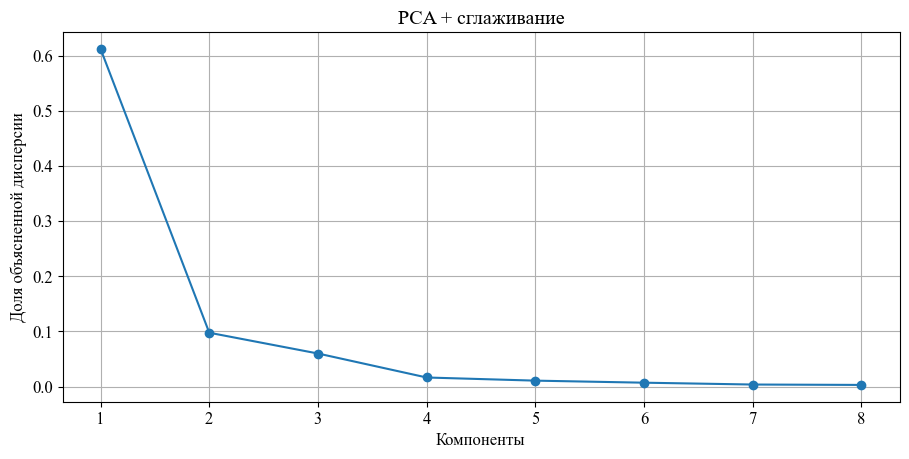

In [23]:
X_train_savgol_pca = pca.fit_transform(X_train_savgol)
X_test_savgol_pca = pca.transform(X_test_savgol)
ev = pca.explained_variance_ratio_

plt.plot(np.arange(1, len(ev) + 1), ev, marker='o')
plt.ylabel('Доля объясненной дисперсии')
plt.xlabel('Компоненты')
plt.title('PCA + сглаживание')
plt.grid(True)
plt.show()

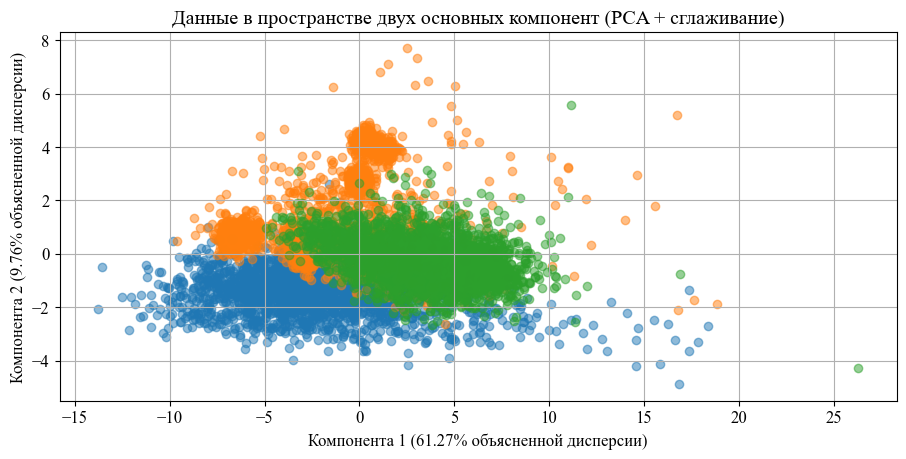

In [24]:
plt.scatter(X_train_savgol_pca[:, 0][Y_train_labels == 0],
            X_train_savgol_pca[:, 1][Y_train_labels == 0], alpha=0.5)
plt.scatter(X_train_savgol_pca[:, 0][Y_train_labels == 1],
            X_train_savgol_pca[:, 1][Y_train_labels == 1], alpha=0.5)
plt.scatter(X_train_savgol_pca[:, 0][Y_train_labels == 2],
            X_train_savgol_pca[:, 1][Y_train_labels == 2], alpha=0.5)
plt.xlabel('Компонента 1 ({:.2f}% объясненной дисперсии)'.format(
    ev[0]*100))
plt.ylabel('Компонента 2 ({:.2f}% объясненной дисперсии)'.format(
    ev[1]*100))
plt.title('Данные в пространстве двух основных компонент (PCA + сглаживание)')
plt.grid(True)
plt.show()

# Построение моделей

In [25]:
def train_and_evaluate(X_train: np.ndarray, 
                       Y_train: np.ndarray,
                       X_test:  np.ndarray,
                       Y_test:  np.ndarray) -> pd.DataFrame:
    models = [LogisticRegression(), SVC(), RandomForestClassifier(), XGBClassifier()]
    evaluation = pd.DataFrame(columns=['Логистическая регрессия', 
                                       'Метод опорных векторов', 
                                       'Случайный лес', 
                                       'Градиентный бустинг'],
                              index=['accuracy', 'precision', 'recall', 'f1'])
    
    for model_index, model in enumerate(models):
        model.fit(X_train, Y_train)
        prediction = model.predict(X_test)
        evaluation.iloc[0, model_index] = accuracy_score(
            Y_test, prediction)
        evaluation.iloc[1, model_index] = precision_score(
            Y_test, prediction, average='weighted')
        evaluation.iloc[2, model_index] = recall_score(
            Y_test, prediction, average='weighted')
        evaluation.iloc[3, model_index] = f1_score(
            Y_test, prediction, average='weighted')

    return evaluation

In [31]:
result_plain = train_and_evaluate(X_train, Y_train_labels, X_test, Y_test_labels)
result_savgol = train_and_evaluate(X_train_savgol, Y_train_labels, X_test_savgol, Y_test_labels)
result_svd = train_and_evaluate(X_train_svd, Y_train_labels, X_test_svd, Y_test_labels)
result_pca = train_and_evaluate(X_train_pca, Y_train_labels, X_test_pca, Y_test_labels)
result_savgol_pca = train_and_evaluate(X_train_savgol_pca, Y_train_labels, X_test_savgol_pca, Y_test_labels)

d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

In [54]:
result_plain

,Логистическая регрессия,Метод опорных векторов,Случайный лес,Градиентный бустинг
accuracy,0.946827,0.941252,0.918096,0.937822
precision,0.947105,0.941308,0.918992,0.938119
recall,0.946827,0.941252,0.918096,0.937822
f1,0.946908,0.941191,0.918168,0.937805


In [55]:
result_savgol

,Логистическая регрессия,Метод опорных векторов,Случайный лес,Градиентный бустинг
accuracy,0.93825,0.929245,0.946398,0.951973
precision,0.938792,0.929218,0.94694,0.952108
recall,0.93825,0.929245,0.946398,0.951973
f1,0.9384,0.929138,0.946478,0.951976


In [56]:
result_pca

,Логистическая регрессия,Метод опорных векторов,Случайный лес,Градиентный бустинг
accuracy,0.862779,0.876072,0.89494,0.890652
precision,0.863211,0.884051,0.895146,0.890817
recall,0.862779,0.876072,0.89494,0.890652
f1,0.862421,0.876011,0.894992,0.890582


In [57]:
result_svd

,Логистическая регрессия,Метод опорных векторов,Случайный лес,Градиентный бустинг
accuracy,0.899228,0.867067,0.904374,0.906947
precision,0.899812,0.872153,0.904745,0.907022
recall,0.899228,0.867067,0.904374,0.906947
f1,0.899224,0.866613,0.904358,0.906929


In [58]:
result_savgol_pca

,Логистическая регрессия,Метод опорных векторов,Случайный лес,Градиентный бустинг
accuracy,0.863636,0.879074,0.897942,0.891509
precision,0.864151,0.886042,0.898361,0.891566
recall,0.863636,0.879074,0.897942,0.891509
f1,0.863298,0.879032,0.897994,0.891392


In [50]:
result_plain.to_excel('tables/nothing.xlsx')
result_savgol.to_excel('tables/savgol.xlsx')
result_svd.to_excel('tables/svd.xlsx')
result_pca.to_excel('tables/pca.xlsx')
result_savgol_pca.to_excel('tables/pca_with_savgol.xlsx')

In [32]:
result_logreg = pd.DataFrame(columns=['Без предобработки',
                                      'Сглаживание',
                                      'SVD',
                                      'PCA',
                                      'Сглаживание и PCA'],
                             index=['accuracy', 'precision', 'recall', 'f1'])
result_svm = result_logreg.copy()
result_rf = result_logreg.copy()
result_xgb = result_logreg.copy()

results_methods = [result_plain,
                   result_savgol,
                   result_svd,
                   result_pca,
                   result_savgol_pca]
for i, res in enumerate(results_methods):
    result_logreg.iloc[:, i] = res['Логистическая регрессия']
    result_svm.iloc[:, i] = res['Метод опорных векторов']
    result_rf.iloc[:, i] = res['Случайный лес']
    result_xgb.iloc[:, i] = res['Градиентный бустинг']

results_models = [result_logreg,
                  result_svm,
                  result_rf,
                  result_xgb]
result_logreg

,Без предобработки,Сглаживание,SVD,PCA,Сглаживание и PCA
accuracy,0.928786,0.925354,0.897469,0.928786,0.924925
precision,0.928614,0.925159,0.897944,0.928691,0.924828
recall,0.928786,0.925354,0.897469,0.928786,0.924925
f1,0.928616,0.925114,0.897457,0.928645,0.924722


In [33]:
result_accuracy = []
result_precision = []
result_recall = []
result_fscore = []

model_names = ['Логистическая регрессия', 'Метод опорных векторов', 'Случайный лес', 'Градиентный бустинг']
method_names = ['Без предобработки', 'Сглаживание', 'SVD', 'PCA', 'Сглаживание и PCA']
case_names = []

for i, model_name in enumerate(model_names):
    for j, method_name in enumerate(method_names):
        case_names.append(method_name + ' + ' + model_name)
        result_accuracy.append(results_models[i].iloc[0, j])
        result_precision.append(results_models[i].iloc[1, j])
        result_recall.append(results_models[i].iloc[2, j])
        result_fscore.append(results_models[i].iloc[3, j])

case_names = np.array(case_names)
result_accuracy = np.array(result_accuracy)
result_precision = np.array(result_precision)
result_recall = np.array(result_recall)
result_fscore = np.array(result_fscore)
results_criteria = [result_accuracy,
                    result_precision,
                    result_recall,
                    result_fscore]

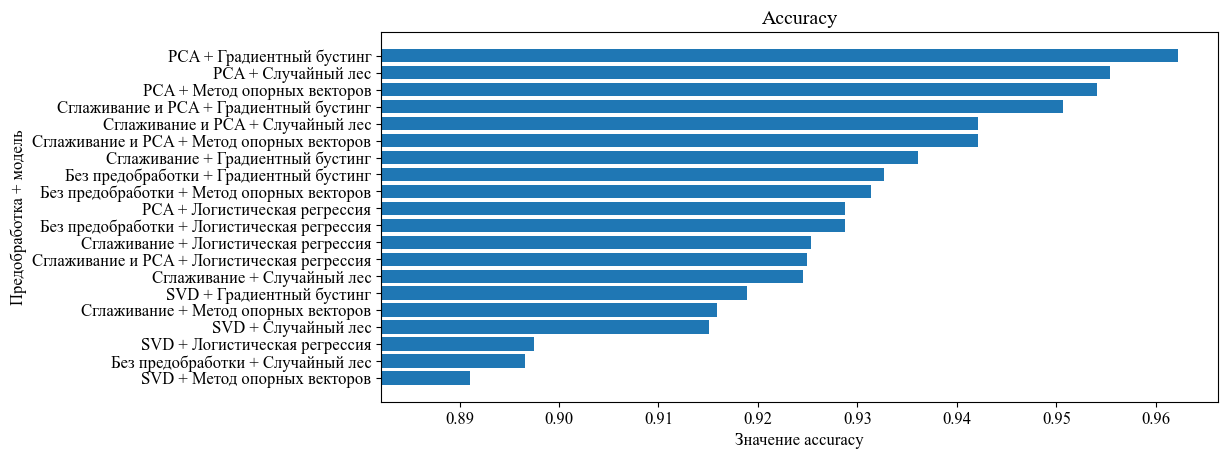

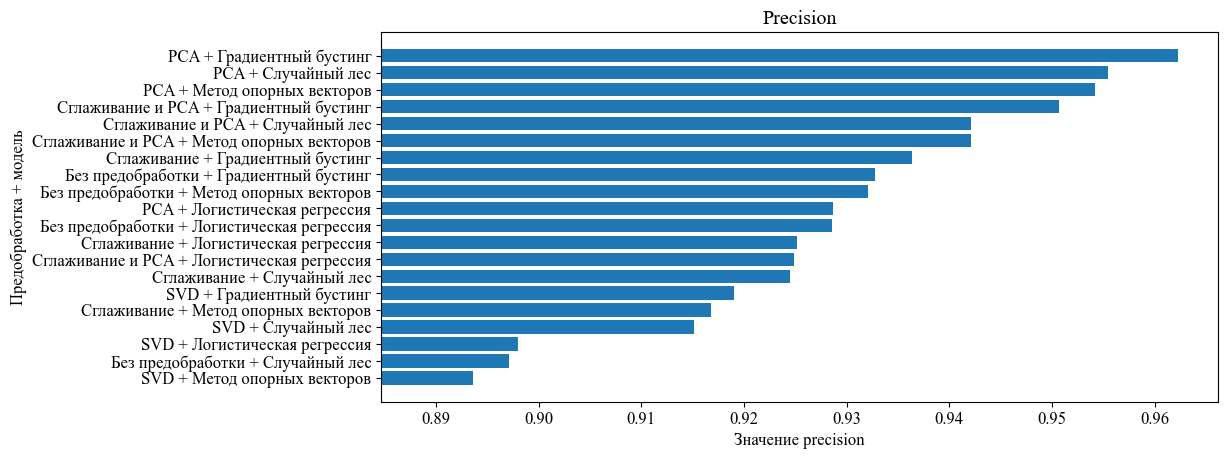

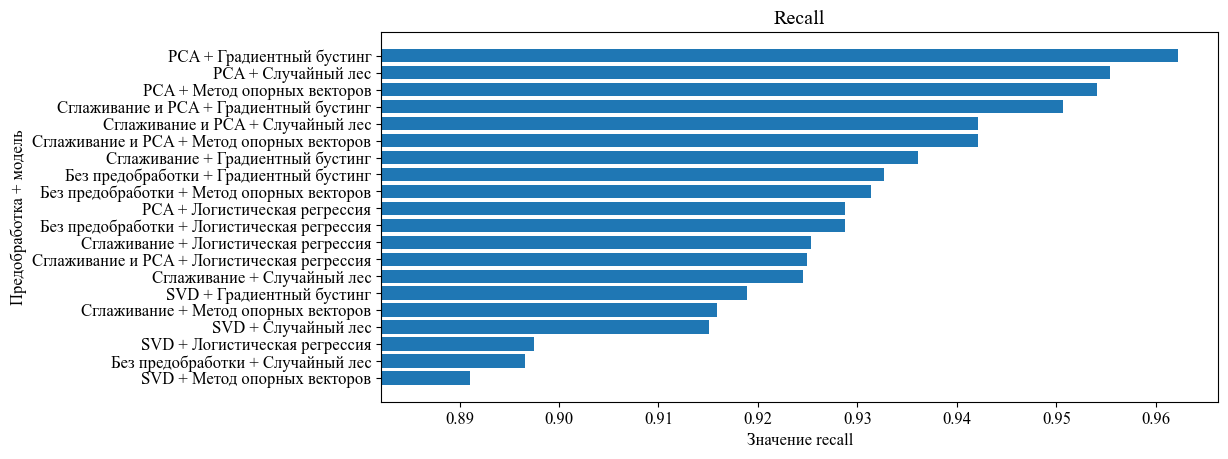

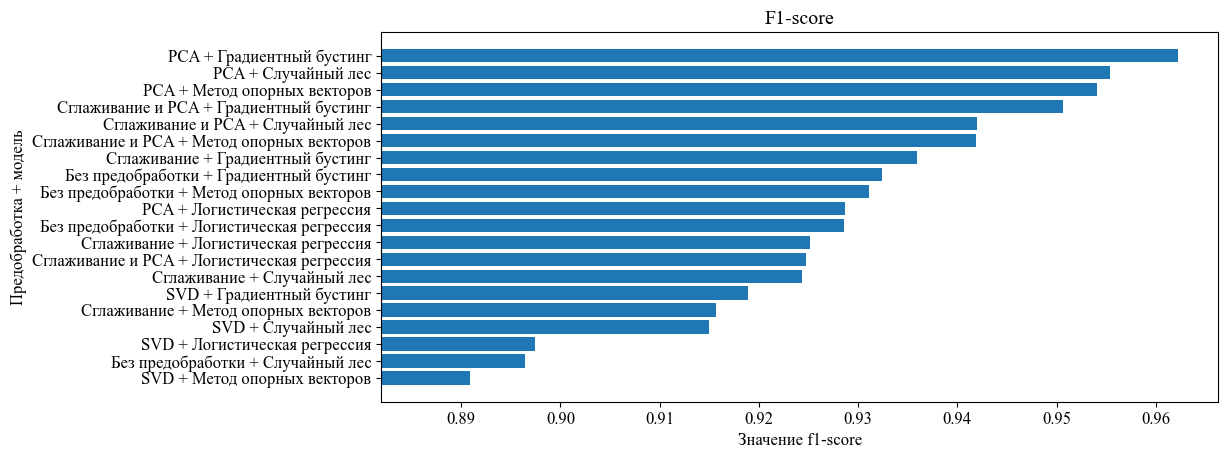

In [34]:
criteria_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']
for ind, criteria in enumerate(criteria_names):
    args = results_criteria[ind].argsort()
    plt.barh(case_names[args], results_criteria[ind][args] -
            np.min(results_criteria[ind])*0.99, left=np.min(results_criteria[ind])*0.99)
    plt.xlabel('Значение ' + criteria.lower())
    plt.ylabel('Предобработка + модель')
    plt.title(criteria)
    plt.show()

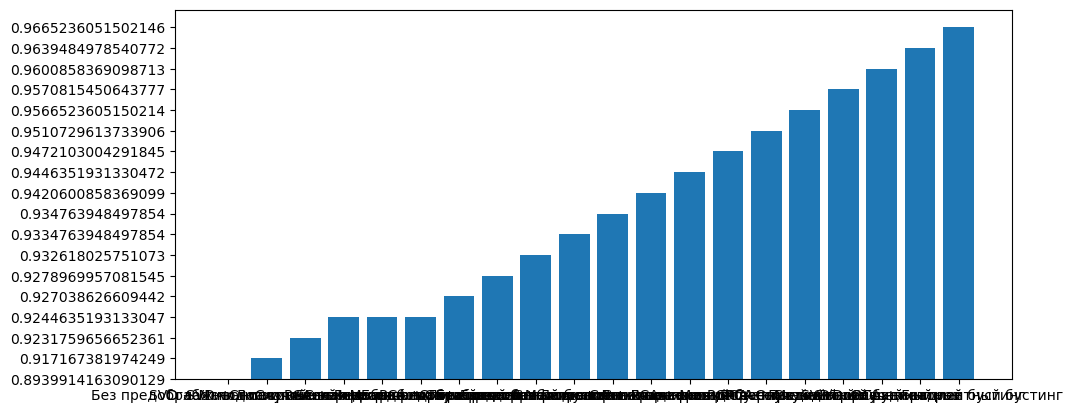

In [114]:
plt.bar(x=results_criteria[0][:, 0], height=results_criteria[0][:, 1])
plt.show()

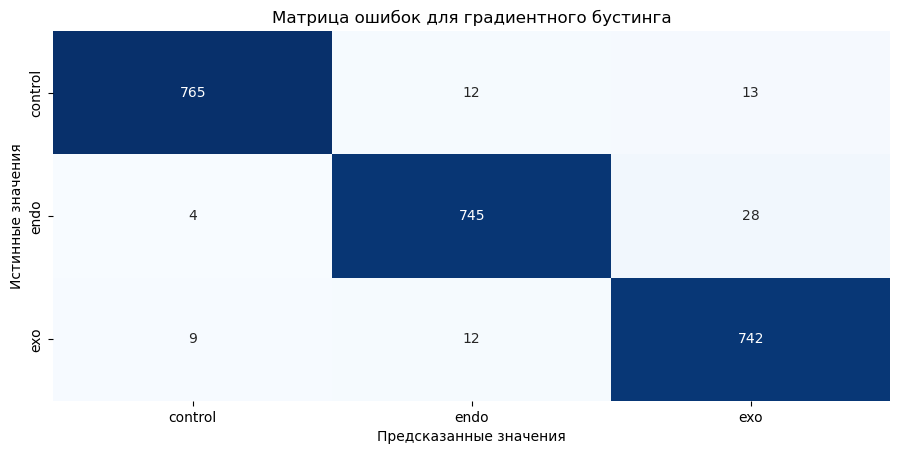

In [18]:
xgb = XGBClassifier()
xgb.fit(X_train_pca, Y_train_labels)
prediction = xgb.predict(X_test_pca)
cm = confusion_matrix(Y_test_labels, prediction)
sns.heatmap(cm, annot=True, xticklabels=['control', 'endo', 'exo'], yticklabels=['control', 'endo', 'exo'], cmap='Blues', fmt='d', cbar=False)
plt.title('Матрица ошибок для градиентного бустинга')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()

In [45]:
model = XGBClassifier()
# Обучаем модель
model.fit(X_train, Y_train_labels)

# Создаем объект explainer
explainer = shap.TreeExplainer(model, X_train)

# Вычисляем значения SHAP
shap_values = explainer.shap_values(X_train)

# Визуализируем важность признаков
shap.summary_plot(shap_values, X_train)

100%|===================| 20946/20964 [04:31<00:00]        

SystemError: <built-in function dense_tree_shap> returned a result with an exception set

In [23]:
shap_values.shape

(6988, 1015, 3)

In [29]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train_labels)

RandomForestClassifier()

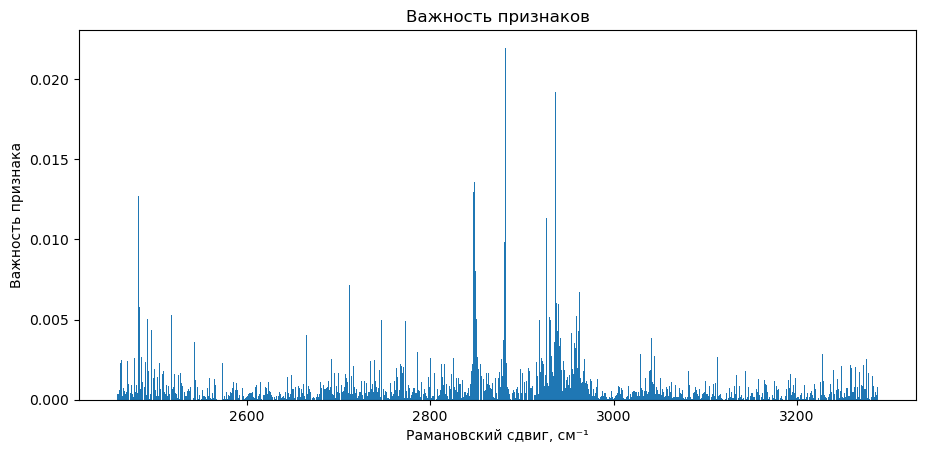

In [46]:
sorted_features = rf.feature_importances_.argsort()
plt.bar(wavelengths[sorted_features],
         rf.feature_importances_[sorted_features])
plt.xlabel('Рамановский сдвиг, см⁻¹')
plt.ylabel('Важность признака')
plt.title('Важность признаков')
plt.show()

In [51]:
model = XGBClassifier()
model.fit(X_train, Y_train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

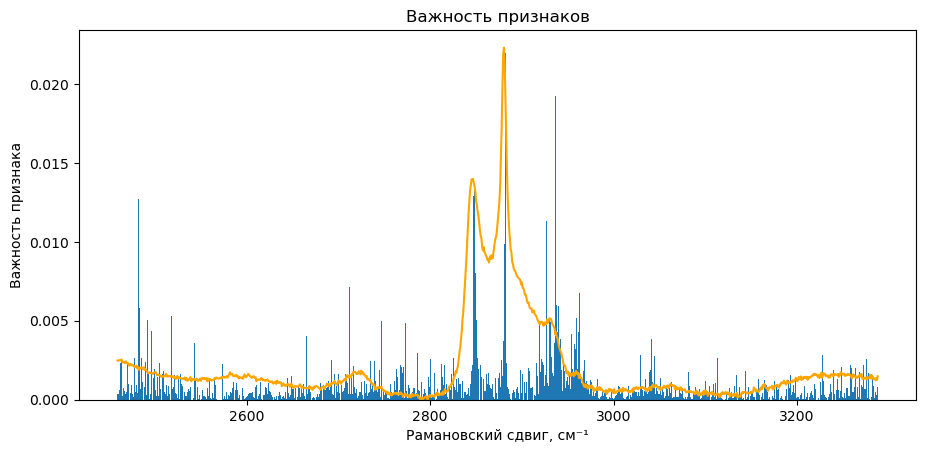

In [66]:
sorted_features = model.feature_importances_.argsort()
plt.bar(wavelengths[sorted_features],
         model.feature_importances_[sorted_features])
plt.plot(wavelengths, (avg - bl - np.min(avg - bl)) *
        np.max(model.feature_importances_) / np.max(avg - bl), color='orange')
plt.xlabel('Рамановский сдвиг, см⁻¹')
plt.ylabel('Важность признака')
plt.title('Важность признаков')
plt.show()
#fi = pd.DataFrame({'raman shift': np.flip(wavelengths[sorted_features]),
#                   'importance': np.flip(model.feature_importances_[sorted_features])})
#fi.to_excel('tables/feature_importances.xlsx', index=False)

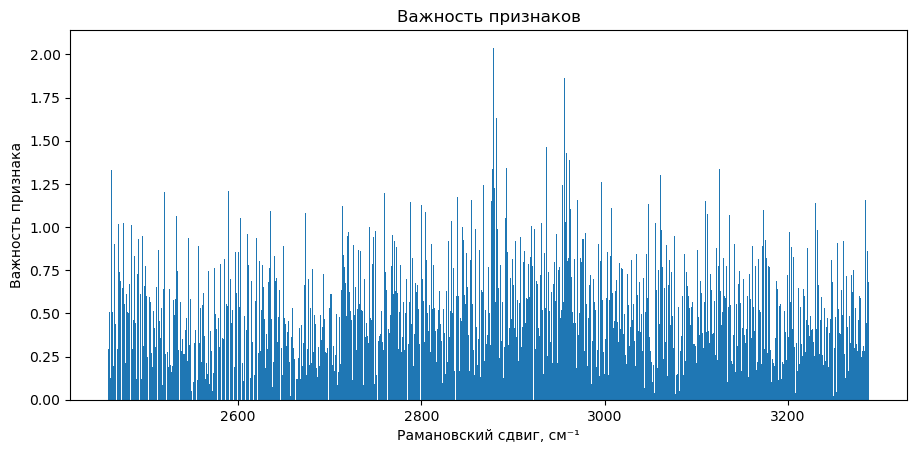

In [36]:
coef = model.coef_

# Для оценки важности каждого признака вычисляем норму весов по всем классам
feature_importance = np.linalg.norm(coef, axis=0)

# Сортируем признаки по их важности
sorted_indices = np.argsort(feature_importance)[::-1]
plt.bar(wavelengths[sorted_indices],
        feature_importance[sorted_indices])
plt.xlabel('Рамановский сдвиг, см⁻¹')
plt.ylabel('Важность признака')
plt.title('Важность признаков')
plt.show()

In [78]:
# Попытка в файнтюнинг (провальная)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [80, 100, 150],
    'max_depth': [1, 2, 3, 5, 7],
    #'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    #'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    #'min_child_weight': [1, 3, 5, 7]
}

xgb = XGBClassifier(learning_rate=0.1, gamma=0, min_child_weight=1)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train_pca, Y_train_labels)
# n_estimators=150,learning_rate=0.1,subsample=0.7,n_estimators=85, max_depth=7, colsample_bytree=0.9,
print("Наилучшие гиперпараметры:", grid_search.best_params_)
print("Точность на тестовом наборе данных:", grid_search.best_estimator_.score(X_test_pca, Y_test_labels))

Наилучшие гиперпараметры: {'colsample_bytree': 0.9, 'max_depth': 7, 'n_estimators': 80, 'subsample': 0.7}
Точность на тестовом наборе данных: 0.965236051502146


In [61]:
for n in range(3, 20):
    pca = PCA(n_components=n)
    X_train_savgol_pca = pca.fit_transform(X_train_savgol)
    X_test_savgol_pca = pca.transform(X_test_savgol)
    xgb = XGBClassifier()
    xgb.fit(X_train_savgol_pca, Y_train_labels)
    prediction = xgb.predict(X_test_savgol_pca)
    print(f'Количество компонент: {n}, Accuracy: {accuracy_score(Y_test_labels, prediction)}')

Количество компонент: 3, Accuracy: 0.8915094339622641
Количество компонент: 4, Accuracy: 0.9262435677530018
Количество компонент: 5, Accuracy: 0.9506861063464837
Количество компонент: 6, Accuracy: 0.9665523156089194
Количество компонент: 7, Accuracy: 0.9734133790737565
Количество компонент: 8, Accuracy: 0.9742710120068611
Количество компонент: 9, Accuracy: 0.9751286449399656
Количество компонент: 10, Accuracy: 0.9751286449399656
Количество компонент: 11, Accuracy: 0.9764150943396226
Количество компонент: 12, Accuracy: 0.9772727272727273
Количество компонент: 13, Accuracy: 0.9764150943396226
Количество компонент: 14, Accuracy: 0.9772727272727273
Количество компонент: 15, Accuracy: 0.975557461406518
Количество компонент: 16, Accuracy: 0.9742710120068611
Количество компонент: 17, Accuracy: 0.975557461406518
Количество компонент: 18, Accuracy: 0.9746998284734134
Количество компонент: 19, Accuracy: 0.9751286449399656
